In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
import os

import math
from scipy.spatial.distance import directed_hausdorff
from sklearn.cluster import DBSCAN

In [2]:
# enter path here
path_dynamic = r'' 

In [3]:
df = pd.read_csv(path_dynamic, encoding='gbk', usecols=[0,2,7,8])

In [4]:
df['经度']=pd.to_numeric(df['经度'])
df['纬度']=pd.to_numeric(df['纬度'])

In [18]:
ratio = 0.01
# df_geo = df.sample(int(len(df)*ratio))
df = df.sample(int(len(df)*ratio))

In [19]:
df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [20]:
df_clear = df.drop(df[(df['经度']<70)|(df['经度']>145)|(df['纬度']<4)|(df['纬度']>55)].index)

In [26]:
gdf = gpd.GeoDataFrame(df_clear, geometry=gpd.points_from_xy(df_clear['经度'], df_clear['纬度']))

D:\Software\Coding\Miniconda\envs\ais\lib\site-packages\geopandas\array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


In [48]:
part_world = df_world.cx[60:155, 0:60]

(0.0, 60.0)

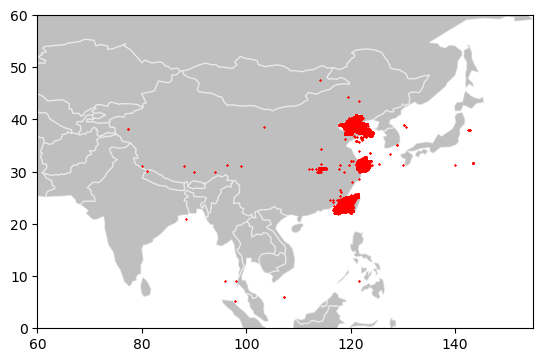

In [30]:
fig,ax = plt.subplots()
part_world.plot(ax=ax,alpha=0.5,facecolor='grey',edgecolor='white')
gdf.plot(ax=ax,color='red',marker='x',markersize=0.5)
ax.set_xlim([60,155])
ax.set_ylim([0,60])

In [12]:
df_clear

,时间,船舶MMSI,经度,纬度
0,2023-01-30 23:59:59,413376990,122.304143,31.102057
1,2023-01-31 00:00:00,414574000,120.617920,38.629153
2,2023-01-31 00:00:00,413324940,119.639500,37.800067
3,2023-01-31 00:00:00,525125006,121.019968,38.483102
4,2023-01-31 00:00:00,413436370,121.958908,38.825000
...,...,...,...,...
9702408,2023-01-31 23:59:59,414532000,120.981155,38.516518
9702409,2023-01-31 23:59:59,414532000,120.981155,38.516518
9702410,2023-01-31 23:59:59,412472110,118.165203,24.220033
9702411,2023-01-31 23:59:59,202106001,118.237143,24.360085


In [21]:
df_clear = df_clear.values

In [22]:
df_clear

array([['2023-01-31 06:26:49', 341049000, 121.762555, 31.30418833333333],
       ['2023-01-31 06:46:56', 413988000, 121.03376666666666,
        38.49966666666667],
       ['2023-01-31 20:07:56', 413311000, 120.472815, 39.532115],
       ...,
       ['2023-01-31 00:17:45', 414505000, 120.08134666666666, 38.3693],
       ['2023-01-31 10:24:00', 413294630, 118.62438, 24.475781666666663],
       ['2023-01-31 09:24:56', 202210107, 118.22909833333334,
        24.345051666666667]], dtype=object)

In [23]:
df_sort = df_clear[np.lexsort((df_clear[:, 0], df_clear[:, 1]))]

In [24]:
test = []
temp = []
# take out MMSI column
second_column = df_sort[:, 1]
unique_vals, unique_count = np.unique(second_column, return_counts=True)
k = 0
last_count = 0
for i in range(len(df_sort)):
    temp.append(tuple([df_sort[i][2], df_sort[i][3]]))
    if (i - last_count) == unique_count[k]:
        test.append(temp)
        temp = []
        last_count = i
        k += 1
test.append(temp)

In [25]:
traj_list = []
for traj in test:
    traj_list.append(np.vstack(traj))

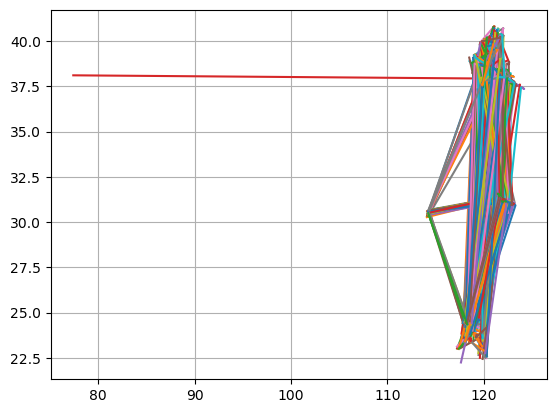

In [26]:
for traj in traj_list:
    plt.plot(traj[:, 0], traj[:, 1])
plt.grid()

# Segment

In [27]:
degree_threshold = 5

for traj_index, traj in enumerate(traj_list):
    
    hold_index_lst = []
    previous_azimuth= 1000
    
    for point_index, point in enumerate(traj[:-1]):
        next_point = traj[point_index + 1]
        diff_vector = next_point - point
        azimuth = (math.degrees(math.atan2(*diff_vector)) + 360) % 360
        
        if abs(azimuth - previous_azimuth) > degree_threshold:
            hold_index_lst.append(point_index)
            previous_azimuth = azimuth
    hold_index_lst.append(traj.shape[0] - 1) # Last point of trajectory is always added
    
    traj_list[traj_index] = traj[hold_index_lst, :]

In [28]:
len(traj_list)

3915

In [29]:
# 3 - Distance matrix

def hausdorff( u, v):
    d = max(directed_hausdorff(u, v)[0], directed_hausdorff(v, u)[0])
    return d

traj_count = len(traj_list)
D = np.zeros((traj_count, traj_count))

# This may take a while
for i in range(traj_count):
    print('{}/{}start'.format(i,9525))
    for j in range(i + 1, traj_count):
        distance = hausdorff(traj_list[i], traj_list[j])
        D[i, j] = distance
        D[j, i] = distance

0/9525start
1/9525start
2/9525start
3/9525start
4/9525start
5/9525start
6/9525start
7/9525start
8/9525start
9/9525start
10/9525start
11/9525start
12/9525start
13/9525start
14/9525start
15/9525start
16/9525start
17/9525start
18/9525start
19/9525start
20/9525start
21/9525start
22/9525start
23/9525start
24/9525start
25/9525start
26/9525start
27/9525start
28/9525start
29/9525start
30/9525start
31/9525start
32/9525start
33/9525start
34/9525start
35/9525start
36/9525start
37/9525start
38/9525start
39/9525start
40/9525start
41/9525start
42/9525start
43/9525start
44/9525start
45/9525start
46/9525start
47/9525start
48/9525start
49/9525start
50/9525start
51/9525start
52/9525start
53/9525start
54/9525start
55/9525start
56/9525start
57/9525start
58/9525start
59/9525start
60/9525start
61/9525start
62/9525start
63/9525start
64/9525start
65/9525start
66/9525start
67/9525start
68/9525start
69/9525start
70/9525start
71/9525start
72/9525start
73/9525start
74/9525start
75/9525start
76/9525start
77/9525st

594/9525start
595/9525start
596/9525start
597/9525start
598/9525start
599/9525start
600/9525start
601/9525start
602/9525start
603/9525start
604/9525start
605/9525start
606/9525start
607/9525start
608/9525start
609/9525start
610/9525start
611/9525start
612/9525start
613/9525start
614/9525start
615/9525start
616/9525start
617/9525start
618/9525start
619/9525start
620/9525start
621/9525start
622/9525start
623/9525start
624/9525start
625/9525start
626/9525start
627/9525start
628/9525start
629/9525start
630/9525start
631/9525start
632/9525start
633/9525start
634/9525start
635/9525start
636/9525start
637/9525start
638/9525start
639/9525start
640/9525start
641/9525start
642/9525start
643/9525start
644/9525start
645/9525start
646/9525start
647/9525start
648/9525start
649/9525start
650/9525start
651/9525start
652/9525start
653/9525start
654/9525start
655/9525start
656/9525start
657/9525start
658/9525start
659/9525start
660/9525start
661/9525start
662/9525start
663/9525start
664/9525start
665/95

1168/9525start
1169/9525start
1170/9525start
1171/9525start
1172/9525start
1173/9525start
1174/9525start
1175/9525start
1176/9525start
1177/9525start
1178/9525start
1179/9525start
1180/9525start
1181/9525start
1182/9525start
1183/9525start
1184/9525start
1185/9525start
1186/9525start
1187/9525start
1188/9525start
1189/9525start
1190/9525start
1191/9525start
1192/9525start
1193/9525start
1194/9525start
1195/9525start
1196/9525start
1197/9525start
1198/9525start
1199/9525start
1200/9525start
1201/9525start
1202/9525start
1203/9525start
1204/9525start
1205/9525start
1206/9525start
1207/9525start
1208/9525start
1209/9525start
1210/9525start
1211/9525start
1212/9525start
1213/9525start
1214/9525start
1215/9525start
1216/9525start
1217/9525start
1218/9525start
1219/9525start
1220/9525start
1221/9525start
1222/9525start
1223/9525start
1224/9525start
1225/9525start
1226/9525start
1227/9525start
1228/9525start
1229/9525start
1230/9525start
1231/9525start
1232/9525start
1233/9525start
1234/9525s

1715/9525start
1716/9525start
1717/9525start
1718/9525start
1719/9525start
1720/9525start
1721/9525start
1722/9525start
1723/9525start
1724/9525start
1725/9525start
1726/9525start
1727/9525start
1728/9525start
1729/9525start
1730/9525start
1731/9525start
1732/9525start
1733/9525start
1734/9525start
1735/9525start
1736/9525start
1737/9525start
1738/9525start
1739/9525start
1740/9525start
1741/9525start
1742/9525start
1743/9525start
1744/9525start
1745/9525start
1746/9525start
1747/9525start
1748/9525start
1749/9525start
1750/9525start
1751/9525start
1752/9525start
1753/9525start
1754/9525start
1755/9525start
1756/9525start
1757/9525start
1758/9525start
1759/9525start
1760/9525start
1761/9525start
1762/9525start
1763/9525start
1764/9525start
1765/9525start
1766/9525start
1767/9525start
1768/9525start
1769/9525start
1770/9525start
1771/9525start
1772/9525start
1773/9525start
1774/9525start
1775/9525start
1776/9525start
1777/9525start
1778/9525start
1779/9525start
1780/9525start
1781/9525s

2262/9525start
2263/9525start
2264/9525start
2265/9525start
2266/9525start
2267/9525start
2268/9525start
2269/9525start
2270/9525start
2271/9525start
2272/9525start
2273/9525start
2274/9525start
2275/9525start
2276/9525start
2277/9525start
2278/9525start
2279/9525start
2280/9525start
2281/9525start
2282/9525start
2283/9525start
2284/9525start
2285/9525start
2286/9525start
2287/9525start
2288/9525start
2289/9525start
2290/9525start
2291/9525start
2292/9525start
2293/9525start
2294/9525start
2295/9525start
2296/9525start
2297/9525start
2298/9525start
2299/9525start
2300/9525start
2301/9525start
2302/9525start
2303/9525start
2304/9525start
2305/9525start
2306/9525start
2307/9525start
2308/9525start
2309/9525start
2310/9525start
2311/9525start
2312/9525start
2313/9525start
2314/9525start
2315/9525start
2316/9525start
2317/9525start
2318/9525start
2319/9525start
2320/9525start
2321/9525start
2322/9525start
2323/9525start
2324/9525start
2325/9525start
2326/9525start
2327/9525start
2328/9525s

2809/9525start
2810/9525start
2811/9525start
2812/9525start
2813/9525start
2814/9525start
2815/9525start
2816/9525start
2817/9525start
2818/9525start
2819/9525start
2820/9525start
2821/9525start
2822/9525start
2823/9525start
2824/9525start
2825/9525start
2826/9525start
2827/9525start
2828/9525start
2829/9525start
2830/9525start
2831/9525start
2832/9525start
2833/9525start
2834/9525start
2835/9525start
2836/9525start
2837/9525start
2838/9525start
2839/9525start
2840/9525start
2841/9525start
2842/9525start
2843/9525start
2844/9525start
2845/9525start
2846/9525start
2847/9525start
2848/9525start
2849/9525start
2850/9525start
2851/9525start
2852/9525start
2853/9525start
2854/9525start
2855/9525start
2856/9525start
2857/9525start
2858/9525start
2859/9525start
2860/9525start
2861/9525start
2862/9525start
2863/9525start
2864/9525start
2865/9525start
2866/9525start
2867/9525start
2868/9525start
2869/9525start
2870/9525start
2871/9525start
2872/9525start
2873/9525start
2874/9525start
2875/9525s

3357/9525start
3358/9525start
3359/9525start
3360/9525start
3361/9525start
3362/9525start
3363/9525start
3364/9525start
3365/9525start
3366/9525start
3367/9525start
3368/9525start
3369/9525start
3370/9525start
3371/9525start
3372/9525start
3373/9525start
3374/9525start
3375/9525start
3376/9525start
3377/9525start
3378/9525start
3379/9525start
3380/9525start
3381/9525start
3382/9525start
3383/9525start
3384/9525start
3385/9525start
3386/9525start
3387/9525start
3388/9525start
3389/9525start
3390/9525start
3391/9525start
3392/9525start
3393/9525start
3394/9525start
3395/9525start
3396/9525start
3397/9525start
3398/9525start
3399/9525start
3400/9525start
3401/9525start
3402/9525start
3403/9525start
3404/9525start
3405/9525start
3406/9525start
3407/9525start
3408/9525start
3409/9525start
3410/9525start
3411/9525start
3412/9525start
3413/9525start
3414/9525start
3415/9525start
3416/9525start
3417/9525start
3418/9525start
3419/9525start
3420/9525start
3421/9525start
3422/9525start
3423/9525s

In [62]:
# Utility Functions

color_lst = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_lst.extend(['firebrick', 'olive', 'indigo', 'khaki', 'teal', 'saddlebrown', 
                 'skyblue', 'coral', 'darkorange', 'lime', 'darkorchid', 'dimgray'])

def plot_cluster(traj_lst, cluster_lst):
    '''
    Plots given trajectories with a color that is specific for every trajectory's own cluster index.
    Outlier trajectories which are specified with -1 in `cluster_lst` are plotted dashed with black color
    '''
    cluster_count = np.max(cluster_lst) + 1
    
    for traj, cluster in zip(traj_lst, cluster_lst):
        
        if cluster == -1:
            # Means it it a noisy trajectory, paint it black
            plt.plot(traj[:, 0], traj[:, 1], c='k', linestyle='dashed')
        
        else:
            plt.plot(traj[:, 0], traj[:, 1], c=color_lst[cluster % len(color_lst)])
    plt.grid()

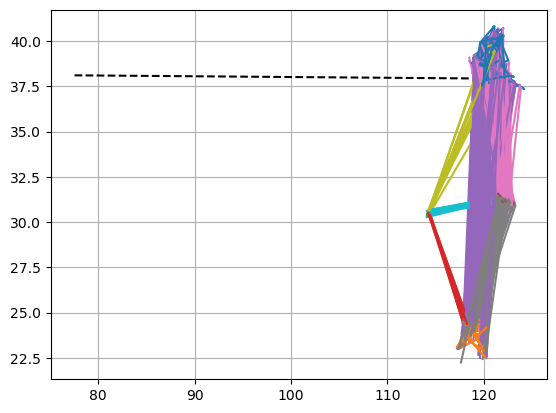

In [46]:
mdl = DBSCAN(eps=40, min_samples=5)
cluster_lst = mdl.fit_predict(D)
plot_cluster(traj_list, cluster_lst)

In [50]:
part_world = df_world.cx[60:155, 0:60]

In [59]:
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题

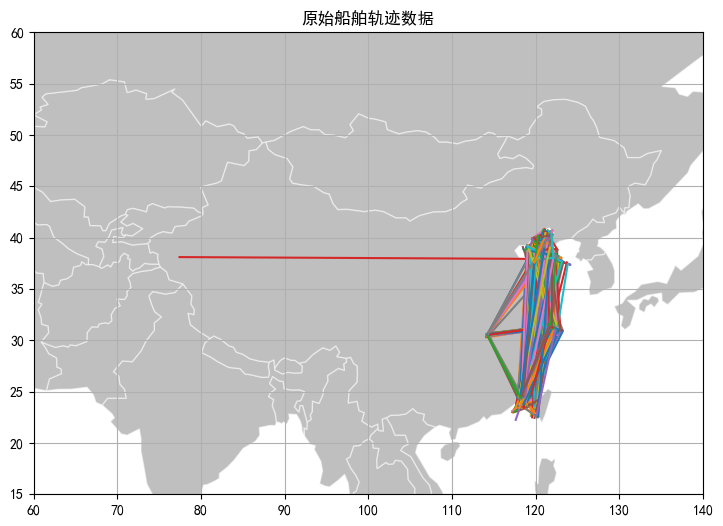

In [63]:
fig,ax = plt.subplots(figsize=(12,6))
part_world.plot(ax=ax,alpha=0.5,facecolor='grey',edgecolor='white')
ax.set_xlim([60,140])
ax.set_ylim([15,60])
for traj in traj_list:
    plt.plot(traj[:, 0], traj[:, 1])
plt.grid()
plt.title('原始船舶轨迹数据')
plt.savefig('original.png',dpi=500,bbox_inches='tight')

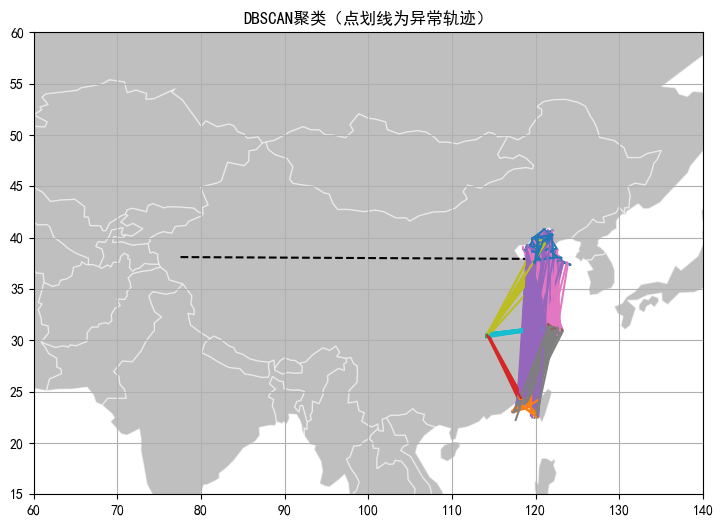

In [65]:
fig,ax = plt.subplots(figsize=(12,6))
part_world.plot(ax=ax,alpha=0.5,facecolor='grey',edgecolor='white')
ax.set_xlim([60,140])
ax.set_ylim([15,60])
plot_cluster(traj_list, cluster_lst)
plt.title('DBSCAN聚类（点划线为异常轨迹）')
plt.savefig('DBSCAN.png',dpi=500,bbox_inches='tight')